<a href="https://colab.research.google.com/github/michp15/DSC514_NLP_Project/blob/main/prepare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from IPython.display import clear_output

In [ ]:
!pip install python-dotenv

clear_output()

In [ ]:
import pandas as pd
import numpy as np
from google import genai
import os
from dotenv import load_dotenv
import time
from tqdm import tqdm
import re
from fractions import Fraction
import unicodedata
from concurrent.futures import ThreadPoolExecutor, as_completed

In [ ]:
%cd /content/drive/MyDrive/2nd semester msc/NLP/project

/content/drive/MyDrive/2nd semester msc/NLP/project


In [ ]:
df = pd.read_csv("cleaned_full_dataset.csv")

In [ ]:
df.head()

,Unnamed: 0,title,ingredients,directions,link,source,NER,ingredients_count,NER_count,directions_count
0,0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""in a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu...",6,6,60
1,1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[""beef"", ""chicken breasts"", ""cream of mushroom...",5,4,29
2,2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""in a slow cooker, combine all ingredients. c...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar...",8,6,30
3,3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""boil and debone chicken."", ""put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[""chicken"", ""chicken gravy"", ""cream of mushroo...",5,4,63
4,4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[""peanut butter"", ""graham cracker crumbs"", ""bu...",5,5,35


In [ ]:
df.columns

Index(['Unnamed: 0', 'title', 'ingredients', 'directions', 'link', 'source',
       'NER', 'ingredients_count', 'NER_count', 'directions_count'],
      dtype='object')

In [ ]:
df = df.drop(['Unnamed: 0', 'title', 'link', 'source'], axis=1)

In [ ]:
df.head()

,ingredients,directions,NER,ingredients_count,NER_count,directions_count
0,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""in a heavy 2-quart saucepan, mix brown sugar...","[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu...",6,6,60
1,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""place chipped beef on bottom of baking dish....","[""beef"", ""chicken breasts"", ""cream of mushroom...",5,4,29
2,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""in a slow cooker, combine all ingredients. c...","[""frozen corn"", ""cream cheese"", ""butter"", ""gar...",8,6,30
3,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""boil and debone chicken."", ""put bite size pi...","[""chicken"", ""chicken gravy"", ""cream of mushroo...",5,4,63
4,"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""combine first four ingredients and press in ...","[""peanut butter"", ""graham cracker crumbs"", ""bu...",5,5,35


In [ ]:
df['directions_count'] = df[df['directions_count'] > 0]['directions_count']
df['NER_count'] = df[df['NER_count'] > 0]['NER_count']
df['ingredients_count'] = df[df['ingredients_count'] > 0]['ingredients_count']

In [ ]:
df.shape

(2231141, 6)

In [ ]:
print('directions_count_min: ', df['directions_count'].min())
print('ner_count_min: ', df['NER_count'].min())
print('ingredients_count_min: ', df['ingredients_count'].min())

print('\n')

print('directions_count_max: ', df['directions_count'].max())
print('ner_count_max: ', df['NER_count'].max())
print('ingredients_count_max: ', df['ingredients_count'].max())

directions_count_min:  1.0
ner_count_min:  1
ingredients_count_min:  1


directions_count_max:  2649.0
ner_count_max:  402
ingredients_count_max:  486


In [ ]:
df = df.dropna()

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.shape

(2230557, 6)

<Axes: >

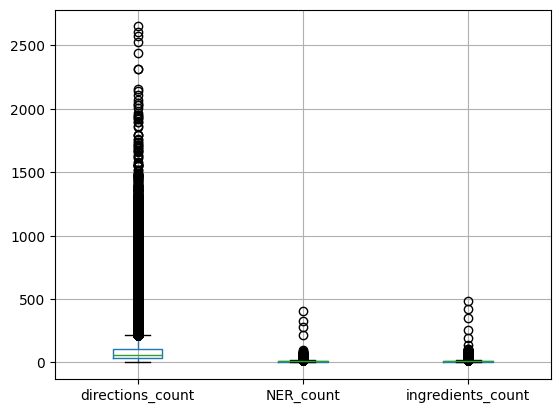

In [ ]:
df.boxplot(column=['directions_count', 'NER_count', 'ingredients_count'])

<Axes: >

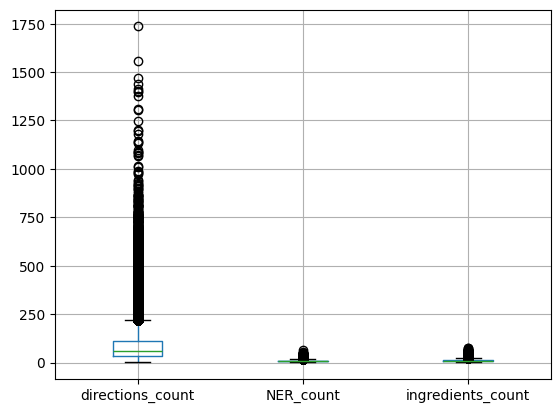

In [ ]:
df.sample(n=120_000, random_state=42).boxplot(column=['directions_count', 'NER_count', 'ingredients_count'])

In [ ]:
df = df.sample(n=120_000, random_state=42)

In [ ]:
print('directions_count_min: ', df['directions_count'].min())
print('ner_count_min: ', df['NER_count'].min())
print('ingredients_count_min: ', df['ingredients_count'].min())

print('\n')

print('directions_count_max: ', df['directions_count'].max())
print('ner_count_max: ', df['NER_count'].max())
print('ingredients_count_max: ', df['ingredients_count'].max())

directions_count_min:  1.0
ner_count_min:  1
ingredients_count_min:  1


directions_count_max:  1736.0
ner_count_max:  64
ingredients_count_max:  77


In [ ]:
df.head()

,ingredients,directions,NER,ingredients_count,NER_count,directions_count
1557310,"[""6 cups rice krispies"", ""2 cups reese's peanu...","[""combine the rice krispies and chopped peanut...","[""rice krispies"", ""miniatures"", ""marshmallows""...",8,6,219.0
1014704,"[""4 boneless skinless chicken breasts"", ""6 spr...","[""heat the oven to 350 degree f/180 degrees c....","[""chicken breasts"", ""oregano"", ""onion"", ""garli...",18,13,131.0
1984359,"[""1 (7 1/2 ounce) can refrigerated biscuits"", ...","[""melt oleo."", ""dip each biscuit in oleo, then...","[""refrigerated biscuits"", ""oleo"", ""brown sugar...",5,5,44.0
1326655,"[""2 pounds ground beef or turkey"", ""2 pounds r...","[""brown meat in a kettle with a little oil"", ""...","[""ground beef"", ""beef"", ""garlic"", ""paprika"", ""...",21,15,73.0
990311,"[""3 lbs beef round steak"", ""all-purpose flour""...","[""cut steaks into strips measuring 3 to 4 inch...","[""beef round steak"", ""flour"", ""salt"", ""onion"",...",9,8,290.0


In [ ]:
#df = df.drop(['NER', 'directions_count', 'NER_count', 'ingredients_count'], axis=1)

In [ ]:
df.head()

,ingredients,directions,NER,ingredients_count,NER_count,directions_count
1557310,"[""6 cups rice krispies"", ""2 cups reese's peanu...","[""combine the rice krispies and chopped peanut...","[""rice krispies"", ""miniatures"", ""marshmallows""...",8,6,219.0
1014704,"[""4 boneless skinless chicken breasts"", ""6 spr...","[""heat the oven to 350 degree f/180 degrees c....","[""chicken breasts"", ""oregano"", ""onion"", ""garli...",18,13,131.0
1984359,"[""1 (7 1/2 ounce) can refrigerated biscuits"", ...","[""melt oleo."", ""dip each biscuit in oleo, then...","[""refrigerated biscuits"", ""oleo"", ""brown sugar...",5,5,44.0
1326655,"[""2 pounds ground beef or turkey"", ""2 pounds r...","[""brown meat in a kettle with a little oil"", ""...","[""ground beef"", ""beef"", ""garlic"", ""paprika"", ""...",21,15,73.0
990311,"[""3 lbs beef round steak"", ""all-purpose flour""...","[""cut steaks into strips measuring 3 to 4 inch...","[""beef round steak"", ""flour"", ""salt"", ""onion"",...",9,8,290.0


In [ ]:
#df.to_csv("cleaned_full_dataset_2.csv")

In [ ]:
#df = pd.read_csv("cleaned_full_dataset_2.csv")

In [ ]:
#df.head()

In [ ]:
df.columns

Index(['ingredients', 'directions', 'NER', 'ingredients_count', 'NER_count',
       'directions_count'],
      dtype='object')

In [ ]:
#df = df.drop(['Unnamed: 0'], axis=1)

In [ ]:
df.head()

,ingredients,directions,NER,ingredients_count,NER_count,directions_count
1557310,"[""6 cups rice krispies"", ""2 cups reese's peanu...","[""combine the rice krispies and chopped peanut...","[""rice krispies"", ""miniatures"", ""marshmallows""...",8,6,219.0
1014704,"[""4 boneless skinless chicken breasts"", ""6 spr...","[""heat the oven to 350 degree f/180 degrees c....","[""chicken breasts"", ""oregano"", ""onion"", ""garli...",18,13,131.0
1984359,"[""1 (7 1/2 ounce) can refrigerated biscuits"", ...","[""melt oleo."", ""dip each biscuit in oleo, then...","[""refrigerated biscuits"", ""oleo"", ""brown sugar...",5,5,44.0
1326655,"[""2 pounds ground beef or turkey"", ""2 pounds r...","[""brown meat in a kettle with a little oil"", ""...","[""ground beef"", ""beef"", ""garlic"", ""paprika"", ""...",21,15,73.0
990311,"[""3 lbs beef round steak"", ""all-purpose flour""...","[""cut steaks into strips measuring 3 to 4 inch...","[""beef round steak"", ""flour"", ""salt"", ""onion"",...",9,8,290.0


In [ ]:
df.memory_usage()

,0
Index,960000
ingredients,960000
directions,960000
NER,960000
ingredients_count,960000
NER_count,960000
directions_count,960000


In [ ]:
# Replace Unicode fractions like ½ → 1/2
def convert_unicode_fractions(text):
    unicode_fractions = {
        '¼': '1/4', '½': '1/2', '¾': '3/4',
        '⅐': '1/7', '⅑': '1/9', '⅒': '1/10',
        '⅓': '1/3', '⅔': '2/3',
        '⅕': '1/5', '⅖': '2/5', '⅗': '3/5', '⅘': '4/5',
        '⅙': '1/6', '⅚': '5/6',
        '⅛': '1/8', '⅜': '3/8', '⅝': '5/8', '⅞': '7/8',
    }
    for sym, frac in unicode_fractions.items():
        text = text.replace(sym, frac)
    return text

# Your units dictionary (for token-level normalization)
units = {
    'c': 'cup', 'c.': 'cup', 'cup': 'cup', 'cups': 'cup',
    'tbsp': 'tablespoon', 'tbsp.': 'tablespoon', 'tbs.': 'tablespoon',
    'tsp': 'teaspoon', 'tsp.': 'teaspoon',
    'oz': 'ounce', 'oz.': 'ounce',
    'lb': 'pound', 'lb.': 'pound',
    'g': 'gram', 'g.': 'gram', 'gr': 'gram', 'gr.': 'gram',
    'ml': 'milliliter', 'ml.': 'milliliter', 'l': 'liter', 'l.': 'liter', 'kg': 'kilogram', 'kg.': 'kilogram',
    'pinch': 'pinch', 'dash': 'dash', 'quart': 'quart', 'qt.': 'quart',
    'pint': 'pint', 'pt.': 'pint',
    'fl oz': 'fluid ounce', 'fl oz.': 'fluid ounce','stick': 'stick',
    'small': 'small portion', 'medium': 'medium portion', 'large': 'large portion',
    'slice': 'slice', 'slices': 'slice',
    'piece': 'piece', 'pieces': 'piece',
    'bunch': 'bunch', 'bag': 'bag',
    'clove': 'clove', 'head': 'head',
    'can': 'can', 'cans': 'can',
    'pkg.': 'package', 'pkg': 'package', 'package': 'package',
    'bottle': 'bottle', 'box': 'box', 'jar': 'jar',
    'ckd': 'cooked', 'ln': 'lean', 'cnd': 'canned', 'frz': 'frozen', 'bld': 'boiled',
    'rstd': 'roasted', 'drnd': 'drained', 'rte': 'ready to eat', 'frsh': 'fresh',
    'skn': 'skin', 'rnd': 'round', 'bf': 'beef', 'brld': 'broiled', 'veg': 'vegetable', 'whl': 'whole',
    'shldr': 'shoulder', 'grds': 'grinds', 'juc': 'juice', 'pdr': 'powder', 'lt': 'light', 'hvy': 'heavy','inst': 'instant',
    'chs': 'cheese', 'bev': 'beverage', 'veal': 'veal', 'drsng': 'dressing'
}

# Regex-based replacements for pattern matching
regex_replacements = {
    r'\btbsp[s.]?\b': 'tablespoon',
    r'\btsp[s.]?\b': 'teaspoon',
    r'\bcup[s.]?\b': 'cup',
    r'\boz[.]?\b': 'ounce',
    r'\blb[.]?\b': 'pound',
    r'\bqt[.]?\b': 'quart',
    r'\bpt[.]?\b': 'pint',
    r'\bfl[.]?\s?oz[.]?\b': 'fluid ounce',
    r'\bgr[.]?\b': 'gram',
    r'\bg\b': 'gram',
    r'\bl\b': 'liter',
    r'\bml\b': 'milliliter',
    r'\bkg\b': 'kilogram',
}

def normalize_ingredient(text):
    text = text.lower()
    text = convert_unicode_fractions(text)

    # Apply regex-based substitutions
    for pattern, repl in regex_replacements.items():
        text = re.sub(pattern, repl, text)

    # Token-based cleanup using the `units` dictionary
    tokens = text.split()
    normalized_tokens = []
    for token in tokens:
        clean = re.sub(r'[^\w.]', '', token)
        normalized_tokens.append(units.get(clean, token))

    text = ' '.join(normalized_tokens)

    # Convert "1 1/2" → "1.5"
    text = re.sub(r'(\d+)\s+(\d+/\d+)', lambda m: str(float(Fraction(m.group(1)) + Fraction(m.group(2)))), text)
    text = re.sub(r'\b(\d+)/(\d+)\b', lambda m: str(round(float(Fraction(m.group())), 2)), text)

    # Remove extra punctuation, multiple spaces
    text = re.sub(r'[\u201c\u201d\'"]', '', text)  # fancy quotes
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
df['normalized_ingredients'] = df['ingredients'].apply(normalize_ingredient)

In [ ]:
df['normalized_ingredients'].iloc[10]

'[1 large portion (24 ounce.) carton 1% cottage cheese, 8 tablespoon. lite sour cream, 1 small portion (3 ounce.) package sugar-free gelatin (any flavor), 6 package non-nutritive sweetener or 0.25 cup sugar, 3 cup fruit (any fruit)]'

In [ ]:
def normalize_direction(text):
    if not isinstance(text, str):
        raise('Error: not text.')

    # Lowercase
    text = text.lower()

    # Normalize unicode (e.g., curly quotes, accents)
    text = unicodedata.normalize('NFKD', text)

    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)

    # Remove emojis and non-ASCII chars
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)

    # Fix common spacing issues
    text = re.sub(r'\s+', ' ', text)

    # Standardize temperature formats
    text = re.sub(r'(\d+)\s?(°?f|degrees f)', r'\1 degrees fahrenheit', text)
    text = re.sub(r'(\d+)\s?(°?c|degrees c)', r'\1 degrees celsius', text)

    # Remove leading/trailing whitespace and trailing punctuation
    text = text.strip()
    text = re.sub(r'[\.\!\?]$', '', text)

    return text

In [ ]:
df['normalized_directions'] = df['directions'].apply(normalize_direction)

In [ ]:
df.head()

,ingredients,directions,NER,ingredients_count,NER_count,directions_count,normalized_ingredients,normalized_directions
1557310,"[""6 cups rice krispies"", ""2 cups reese's peanu...","[""combine the rice krispies and chopped peanut...","[""rice krispies"", ""miniatures"", ""marshmallows""...",8,6,219.0,"[6 cup rice krispies, 2 cup reeses peanut butt...","[""combine the rice krispies and chopped peanut..."
1014704,"[""4 boneless skinless chicken breasts"", ""6 spr...","[""heat the oven to 350 degree f/180 degrees c....","[""chicken breasts"", ""oregano"", ""onion"", ""garli...",18,13,131.0,"[4 boneless skinless chicken breasts, 6 sprigs...","[""heat the oven to 350 degree f/180 degrees ce..."
1984359,"[""1 (7 1/2 ounce) can refrigerated biscuits"", ...","[""melt oleo."", ""dip each biscuit in oleo, then...","[""refrigerated biscuits"", ""oleo"", ""brown sugar...",5,5,44.0,"[1 (7.5 ounce) can refrigerated biscuits, 1 cu...","[""melt oleo."", ""dip each biscuit in oleo, then..."
1326655,"[""2 pounds ground beef or turkey"", ""2 pounds r...","[""brown meat in a kettle with a little oil"", ""...","[""ground beef"", ""beef"", ""garlic"", ""paprika"", ""...",21,15,73.0,"[2 pounds ground beef or turkey, 2 pounds roun...","[""brown meat in a kettle with a little oil"", ""..."
990311,"[""3 lbs beef round steak"", ""all-purpose flour""...","[""cut steaks into strips measuring 3 to 4 inch...","[""beef round steak"", ""flour"", ""salt"", ""onion"",...",9,8,290.0,"[3 lbs beef round steak, all-purpose flour, sa...","[""cut steaks into strips measuring 3 to 4 inch..."


In [ ]:
df['normalized_directions'].iloc[2]

'["melt oleo.", "dip each biscuit in oleo, then brown sugar and nuts.", "put in cake or pie tin.", "make indentation in each biscuit and put about 1 teaspoons cranberry sauce in each.", "bake at 350 degrees fahrenheit for about 10 minutes till brown and crispy.", "yum."]'

In [ ]:
df['directions'].iloc[2]

'["melt oleo.", "dip each biscuit in oleo, then brown sugar and nuts.", "put in cake or pie tin.", "make indentation in each biscuit and put about 1 teaspoons cranberry sauce in each.", "bake at 350f for about 10 minutes till brown and crispy.", "yum."]'

In [ ]:
#df = df.drop(['ingredients', 'directions'], axis=1)

In [ ]:
df.head()

,ingredients,directions,NER,ingredients_count,NER_count,directions_count,normalized_ingredients,normalized_directions
1557310,"[""6 cups rice krispies"", ""2 cups reese's peanu...","[""combine the rice krispies and chopped peanut...","[""rice krispies"", ""miniatures"", ""marshmallows""...",8,6,219.0,"[6 cup rice krispies, 2 cup reeses peanut butt...","[""combine the rice krispies and chopped peanut..."
1014704,"[""4 boneless skinless chicken breasts"", ""6 spr...","[""heat the oven to 350 degree f/180 degrees c....","[""chicken breasts"", ""oregano"", ""onion"", ""garli...",18,13,131.0,"[4 boneless skinless chicken breasts, 6 sprigs...","[""heat the oven to 350 degree f/180 degrees ce..."
1984359,"[""1 (7 1/2 ounce) can refrigerated biscuits"", ...","[""melt oleo."", ""dip each biscuit in oleo, then...","[""refrigerated biscuits"", ""oleo"", ""brown sugar...",5,5,44.0,"[1 (7.5 ounce) can refrigerated biscuits, 1 cu...","[""melt oleo."", ""dip each biscuit in oleo, then..."
1326655,"[""2 pounds ground beef or turkey"", ""2 pounds r...","[""brown meat in a kettle with a little oil"", ""...","[""ground beef"", ""beef"", ""garlic"", ""paprika"", ""...",21,15,73.0,"[2 pounds ground beef or turkey, 2 pounds roun...","[""brown meat in a kettle with a little oil"", ""..."
990311,"[""3 lbs beef round steak"", ""all-purpose flour""...","[""cut steaks into strips measuring 3 to 4 inch...","[""beef round steak"", ""flour"", ""salt"", ""onion"",...",9,8,290.0,"[3 lbs beef round steak, all-purpose flour, sa...","[""cut steaks into strips measuring 3 to 4 inch..."


In [ ]:
df['normalized_ingredients'].iloc[0]

'[6 cup rice krispies, 2 cup reeses peanut butter cup miniatures, unwrapped and chopped (for 2 cup youll need about 8 ounces of candy), 10-0.5 ounces, weight mini marshmallows, 0.25 cup butter, 2 cup chocolate chips, 1-0.5 cup smooth peanut butter]'

In [ ]:
df['normalized_ingredients'] = df['normalized_ingredients'].str.replace(r'[\[\]"]', '', regex=True).str.strip()
df['normalized_directions'] = df['normalized_directions'].str.replace(r'[\[\]"]', '', regex=True).str.strip()

In [ ]:
df.head()

,ingredients,directions,NER,ingredients_count,NER_count,directions_count,normalized_ingredients,normalized_directions
1557310,"[""6 cups rice krispies"", ""2 cups reese's peanu...","[""combine the rice krispies and chopped peanut...","[""rice krispies"", ""miniatures"", ""marshmallows""...",8,6,219.0,"6 cup rice krispies, 2 cup reeses peanut butte...",combine the rice krispies and chopped peanut b...
1014704,"[""4 boneless skinless chicken breasts"", ""6 spr...","[""heat the oven to 350 degree f/180 degrees c....","[""chicken breasts"", ""oregano"", ""onion"", ""garli...",18,13,131.0,"4 boneless skinless chicken breasts, 6 sprigs ...",heat the oven to 350 degree f/180 degrees cels...
1984359,"[""1 (7 1/2 ounce) can refrigerated biscuits"", ...","[""melt oleo."", ""dip each biscuit in oleo, then...","[""refrigerated biscuits"", ""oleo"", ""brown sugar...",5,5,44.0,"1 (7.5 ounce) can refrigerated biscuits, 1 cup...","melt oleo., dip each biscuit in oleo, then bro..."
1326655,"[""2 pounds ground beef or turkey"", ""2 pounds r...","[""brown meat in a kettle with a little oil"", ""...","[""ground beef"", ""beef"", ""garlic"", ""paprika"", ""...",21,15,73.0,"2 pounds ground beef or turkey, 2 pounds round...","brown meat in a kettle with a little oil, add ..."
990311,"[""3 lbs beef round steak"", ""all-purpose flour""...","[""cut steaks into strips measuring 3 to 4 inch...","[""beef round steak"", ""flour"", ""salt"", ""onion"",...",9,8,290.0,"3 lbs beef round steak, all-purpose flour, sal...",cut steaks into strips measuring 3 to 4 inches...


In [ ]:
df['normalized_ingredients'].iloc[11]

'1 cup mayonnaise, 1 cup sour cream, 1 teaspoon. b monde, 1 teaspoon. parsley flakes, 0.5 teaspoon. salt, 1 teaspoon. dill weed, 1 teaspoon. grated onions'

In [ ]:
df['normalized_directions'].iloc[11]

'mix all of the ingredients together.'

In [ ]:
df['normalized_directions'] = df['normalized_directions'].str.replace('.,', ',')

In [ ]:
df.head()

,ingredients,directions,NER,ingredients_count,NER_count,directions_count,normalized_ingredients,normalized_directions
1557310,"[""6 cups rice krispies"", ""2 cups reese's peanu...","[""combine the rice krispies and chopped peanut...","[""rice krispies"", ""miniatures"", ""marshmallows""...",8,6,219.0,"6 cup rice krispies, 2 cup reeses peanut butte...",combine the rice krispies and chopped peanut b...
1014704,"[""4 boneless skinless chicken breasts"", ""6 spr...","[""heat the oven to 350 degree f/180 degrees c....","[""chicken breasts"", ""oregano"", ""onion"", ""garli...",18,13,131.0,"4 boneless skinless chicken breasts, 6 sprigs ...",heat the oven to 350 degree f/180 degrees cels...
1984359,"[""1 (7 1/2 ounce) can refrigerated biscuits"", ...","[""melt oleo."", ""dip each biscuit in oleo, then...","[""refrigerated biscuits"", ""oleo"", ""brown sugar...",5,5,44.0,"1 (7.5 ounce) can refrigerated biscuits, 1 cup...","melt oleo, dip each biscuit in oleo, then brow..."
1326655,"[""2 pounds ground beef or turkey"", ""2 pounds r...","[""brown meat in a kettle with a little oil"", ""...","[""ground beef"", ""beef"", ""garlic"", ""paprika"", ""...",21,15,73.0,"2 pounds ground beef or turkey, 2 pounds round...","brown meat in a kettle with a little oil, add ..."
990311,"[""3 lbs beef round steak"", ""all-purpose flour""...","[""cut steaks into strips measuring 3 to 4 inch...","[""beef round steak"", ""flour"", ""salt"", ""onion"",...",9,8,290.0,"3 lbs beef round steak, all-purpose flour, sal...",cut steaks into strips measuring 3 to 4 inches...


## Get Nutrients

In [ ]:
load_dotenv()

True

In [ ]:
key = os.getenv('key')

In [ ]:
client = genai.Client(api_key=key)

In [ ]:
# 🔁 3. Create batches of rows
def create_batches(data, batch_size):
    for i in range(0, len(data), batch_size):
        yield data[i:i + batch_size]

# 🤖 4. Generate content from Gemini
def get_nutrients_batch(batch, batch_id):
    try:
        prompt = (
            "For each of the following ingredient lists, estimate and return total amounts of: "
            "calories (kcal), protein (g), carbohydrates (g), fat (g), fiber (g), and sugar (g). "
            "Respond in plain text only, one line per list, using this format:\n"
            "calories: X, protein: Yg, carbs: Zg, fat: Ag, fiber: Bg, sugar: Cg\n\n"
        )
        for i, item in enumerate(batch):
            prompt += f"{i+1}. {item}\n"

        response = response = client.models.generate_content(model="gemini-2.0-flash", contents=[prompt])
        time.sleep(0.03)  # stay under 2000 RPM

        output = response.text.strip().split('\n')
        output = [line.strip() for line in output if line.strip()]
        if len(output) != len(batch):
            raise ValueError(f"Mismatch: expected {len(batch)} lines, got {len(output)}")

        return output

    except Exception as e:
        print(f"[Batch {batch_id} ERROR]: {e}")
        return [f"[ERROR]: {e}"] * len(batch)

# 🧪 5. Parse Gemini output into structured data
def parse_nutrient_line(line):
    pattern = r'calories: (\d+), protein: ([\d.]+)g, carbs: ([\d.]+)g, fat: ([\d.]+)g, fiber: ([\d.]+)g, sugar: ([\d.]+)g'
    match = re.search(pattern, line)
    if match:
        return {
            'calories': int(match.group(1)),
            'protein_g': float(match.group(2)),
            'carbs_g': float(match.group(3)),
            'fat_g': float(match.group(4)),
            'fiber_g': float(match.group(5)),
            'sugar_g': float(match.group(6)),
        }
    return {'calories': None, 'protein_g': None, 'carbs_g': None, 'fat_g': None, 'fiber_g': None, 'sugar_g': None}

# 🚀 6. Run batching with threads and tqdm
batch_size = 5
max_workers = 10
all_batches = list(create_batches(df['normalized_ingredients'].dropna().tolist(), batch_size))
results = [None] * len(all_batches)

print(f"Running {len(all_batches)} batches with {max_workers} threads...")

with ThreadPoolExecutor(max_workers=max_workers) as executor:
    future_to_index = {
        executor.submit(get_nutrients_batch, batch, i): i
        for i, batch in enumerate(all_batches)
    }

    for future in tqdm(as_completed(future_to_index), total=len(future_to_index), desc="Processing"):
        idx = future_to_index[future]
        try:
            results[idx] = future.result()
        except Exception as e:
            print(f"[Thread Error] Batch {idx}: {e}")
            results[idx] = [f"[ERROR]: {e}"] * batch_size

# 📦 7. Flatten and parse results
flat_results = [item for batch in results for item in batch]
parsed_results = [parse_nutrient_line(line) for line in flat_results]

Running 24000 batches with 10 threads...


Processing:  24%|██▎       | 5675/24000 [14:45<33:42,  9.06it/s]

[Batch 5674 ERROR]: Mismatch: expected 5 lines, got 4


Processing:  25%|██▍       | 5988/24000 [15:33<41:52,  7.17it/s]

[Batch 5984 ERROR]: Mismatch: expected 5 lines, got 6


Processing:  55%|█████▌    | 13230/24000 [34:07<29:19,  6.12it/s]

[Batch 13230 ERROR]: Mismatch: expected 5 lines, got 4


Processing:  61%|██████    | 14564/24000 [37:32<21:28,  7.32it/s]

[Batch 14565 ERROR]: Mismatch: expected 5 lines, got 4


Processing: 100%|██████████| 24000/24000 [1:01:42<00:00,  6.48it/s]


In [ ]:
nutrients_df = pd.DataFrame(parsed_results)

In [ ]:
nutrients_df.shape

(120000, 6)

In [ ]:
#df.reset_index(drop=True).join(nutrients_df).to_csv("nutrients_df.csv")

In [ ]:
df_nutrients = pd.read_csv("nutrients_df.csv")

In [ ]:
df_nutrients.head()

,Unnamed: 0,normalized_ingredients,normalized_directions,calories,protein_g,carbs_g,fat_g,fiber_g,sugar_g
0,0,"6 cup rice krispies, 2 cup reeses peanut butte...",combine the rice krispies and chopped peanut b...,5950.0,85.0,750.0,300.0,25.0,480.0
1,1,"4 boneless skinless chicken breasts, 6 sprigs ...",heat the oven to 350 degree f/180 degrees cels...,2600.0,280.0,280.0,60.0,40.0,50.0
2,2,"1 (7.5 ounce) can refrigerated biscuits, 1 cup...","melt oleo., dip each biscuit in oleo, then bro...",2800.0,25.0,300.0,180.0,15.0,200.0
3,3,"2 pounds ground beef or turkey, 2 pounds round...","brown meat in a kettle with a little oil, add ...",5700.0,500.0,400.0,250.0,100.0,100.0
4,4,"3 lbs beef round steak, all-purpose flour, sal...",cut steaks into strips measuring 3 to 4 inches...,3500.0,400.0,80.0,150.0,10.0,30.0


In [ ]:
df_nutrients.shape

(120000, 9)

In [ ]:
df.shape

(120000, 8)

In [ ]:
df_nutrients.normalized_ingredients[1]

'4 boneless skinless chicken breasts, 6 sprigs fresh oregano, 1 onion, chopped, 2 cloves garlic, finely chopped, 1 pound tomatoes, peeled and chopped (canned are fine), 1 green capsicum, seeded and diced, salt, pepper, 2 tablespoons paprika, 10 ounces long grain rice, 2 tablespoons tomato puree (or juice from can 1 liter chicken stock, oil, for browning'

In [ ]:
df_nutrients['calories'].describe()

,calories
count,119961.000000
mean,2700.893932
std,4847.902403
min,0.000000
25%,1200.000000
50%,2200.000000
75%,3500.000000
max,654000.000000


In [ ]:
df = df.reset_index(drop=True)

In [ ]:
df.head()

,ingredients,directions,NER,ingredients_count,NER_count,directions_count,normalized_ingredients,normalized_directions
0,"[""6 cups rice krispies"", ""2 cups reese's peanu...","[""combine the rice krispies and chopped peanut...","[""rice krispies"", ""miniatures"", ""marshmallows""...",8,6,219.0,"6 cup rice krispies, 2 cup reeses peanut butte...",combine the rice krispies and chopped peanut b...
1,"[""4 boneless skinless chicken breasts"", ""6 spr...","[""heat the oven to 350 degree f/180 degrees c....","[""chicken breasts"", ""oregano"", ""onion"", ""garli...",18,13,131.0,"4 boneless skinless chicken breasts, 6 sprigs ...",heat the oven to 350 degree f/180 degrees cels...
2,"[""1 (7 1/2 ounce) can refrigerated biscuits"", ...","[""melt oleo."", ""dip each biscuit in oleo, then...","[""refrigerated biscuits"", ""oleo"", ""brown sugar...",5,5,44.0,"1 (7.5 ounce) can refrigerated biscuits, 1 cup...","melt oleo, dip each biscuit in oleo, then brow..."
3,"[""2 pounds ground beef or turkey"", ""2 pounds r...","[""brown meat in a kettle with a little oil"", ""...","[""ground beef"", ""beef"", ""garlic"", ""paprika"", ""...",21,15,73.0,"2 pounds ground beef or turkey, 2 pounds round...","brown meat in a kettle with a little oil, add ..."
4,"[""3 lbs beef round steak"", ""all-purpose flour""...","[""cut steaks into strips measuring 3 to 4 inch...","[""beef round steak"", ""flour"", ""salt"", ""onion"",...",9,8,290.0,"3 lbs beef round steak, all-purpose flour, sal...",cut steaks into strips measuring 3 to 4 inches...


In [ ]:
df = pd.concat([df, df_nutrients[['calories', 'protein_g', 'carbs_g', 'fat_g', 'fiber_g', 'sugar_g']]], axis=1)

In [ ]:
df.head()

,ingredients,directions,NER,ingredients_count,NER_count,directions_count,normalized_ingredients,normalized_directions,calories,protein_g,carbs_g,fat_g,fiber_g,sugar_g
0,"[""6 cups rice krispies"", ""2 cups reese's peanu...","[""combine the rice krispies and chopped peanut...","[""rice krispies"", ""miniatures"", ""marshmallows""...",8,6,219.0,"6 cup rice krispies, 2 cup reeses peanut butte...",combine the rice krispies and chopped peanut b...,5950.0,85.0,750.0,300.0,25.0,480.0
1,"[""4 boneless skinless chicken breasts"", ""6 spr...","[""heat the oven to 350 degree f/180 degrees c....","[""chicken breasts"", ""oregano"", ""onion"", ""garli...",18,13,131.0,"4 boneless skinless chicken breasts, 6 sprigs ...",heat the oven to 350 degree f/180 degrees cels...,2600.0,280.0,280.0,60.0,40.0,50.0
2,"[""1 (7 1/2 ounce) can refrigerated biscuits"", ...","[""melt oleo."", ""dip each biscuit in oleo, then...","[""refrigerated biscuits"", ""oleo"", ""brown sugar...",5,5,44.0,"1 (7.5 ounce) can refrigerated biscuits, 1 cup...","melt oleo, dip each biscuit in oleo, then brow...",2800.0,25.0,300.0,180.0,15.0,200.0
3,"[""2 pounds ground beef or turkey"", ""2 pounds r...","[""brown meat in a kettle with a little oil"", ""...","[""ground beef"", ""beef"", ""garlic"", ""paprika"", ""...",21,15,73.0,"2 pounds ground beef or turkey, 2 pounds round...","brown meat in a kettle with a little oil, add ...",5700.0,500.0,400.0,250.0,100.0,100.0
4,"[""3 lbs beef round steak"", ""all-purpose flour""...","[""cut steaks into strips measuring 3 to 4 inch...","[""beef round steak"", ""flour"", ""salt"", ""onion"",...",9,8,290.0,"3 lbs beef round steak, all-purpose flour, sal...",cut steaks into strips measuring 3 to 4 inches...,3500.0,400.0,80.0,150.0,10.0,30.0


In [ ]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile) -> run 3 times
Q1 = df['calories'].quantile(0.25)
Q3 = df['calories'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df = df[(df['calories'] >= lower_bound) & (df['calories'] <= upper_bound)]

<Axes: >

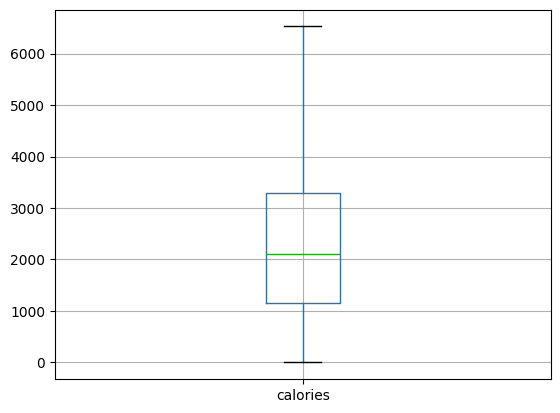

In [ ]:
df.boxplot(column=['calories'])

In [ ]:
df.shape

(114631, 14)

In [ ]:
df[df.calories <= 1200].shape

(31329, 14)

In [ ]:
#df.to_csv("data_with_nutrients_final.csv", index=False)

In [ ]:
df_with_nutrients = pd.read_csv("data_with_nutrients_final.csv")

In [ ]:
df_with_nutrients.head()

,ingredients,directions,NER,ingredients_count,NER_count,directions_count,normalized_ingredients,normalized_directions,calories,protein_g,carbs_g,fat_g,fiber_g,sugar_g
0,"[""6 cups rice krispies"", ""2 cups reese's peanu...","[""combine the rice krispies and chopped peanut...","[""rice krispies"", ""miniatures"", ""marshmallows""...",8,6,219.0,"6 cup rice krispies, 2 cup reeses peanut butte...",combine the rice krispies and chopped peanut b...,5950.0,85.0,750.0,300.0,25.0,480.0
1,"[""4 boneless skinless chicken breasts"", ""6 spr...","[""heat the oven to 350 degree f/180 degrees c....","[""chicken breasts"", ""oregano"", ""onion"", ""garli...",18,13,131.0,"4 boneless skinless chicken breasts, 6 sprigs ...",heat the oven to 350 degree f/180 degrees cels...,2600.0,280.0,280.0,60.0,40.0,50.0
2,"[""1 (7 1/2 ounce) can refrigerated biscuits"", ...","[""melt oleo."", ""dip each biscuit in oleo, then...","[""refrigerated biscuits"", ""oleo"", ""brown sugar...",5,5,44.0,"1 (7.5 ounce) can refrigerated biscuits, 1 cup...","melt oleo, dip each biscuit in oleo, then brow...",2800.0,25.0,300.0,180.0,15.0,200.0
3,"[""2 pounds ground beef or turkey"", ""2 pounds r...","[""brown meat in a kettle with a little oil"", ""...","[""ground beef"", ""beef"", ""garlic"", ""paprika"", ""...",21,15,73.0,"2 pounds ground beef or turkey, 2 pounds round...","brown meat in a kettle with a little oil, add ...",5700.0,500.0,400.0,250.0,100.0,100.0
4,"[""3 lbs beef round steak"", ""all-purpose flour""...","[""cut steaks into strips measuring 3 to 4 inch...","[""beef round steak"", ""flour"", ""salt"", ""onion"",...",9,8,290.0,"3 lbs beef round steak, all-purpose flour, sal...",cut steaks into strips measuring 3 to 4 inches...,3500.0,400.0,80.0,150.0,10.0,30.0


<Axes: >

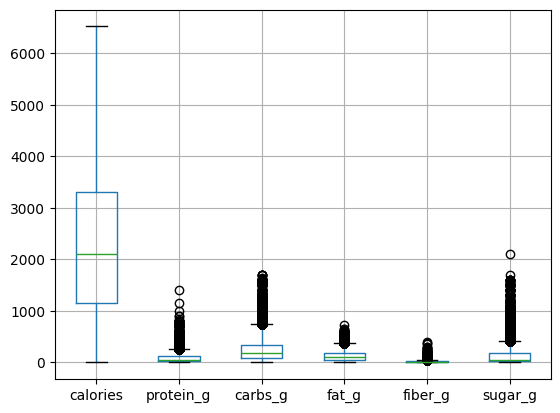

In [ ]:
df_with_nutrients.boxplot(column=['calories', 'protein_g', 'carbs_g', 'fat_g', 'fiber_g', 'sugar_g'])